# Layered surfaces for fiber segmentation

Notebook author: H. Martin Kjer (hmkj@dtu.dk)


## Note
Based on work from Niels Jeppensen


## References

In [1]:
# Package imports
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread


'1.11.1'

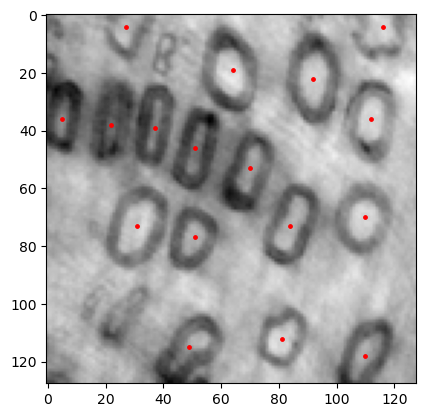

Number of objects: 17


In [2]:
# Load data example
path = '../resources/img2d/nerves.png'
data = imread(path).astype(np.int32)
data_centers = imread(path.replace('nerves', 'nerves_centers'))

# Get center positions.
centers = np.transpose(np.where(data_centers))
idx = centers[:,2] == 0
centers = centers[idx,0:2]
data = data[:,:,0]

# Show image with centers.
plt.imshow(data, cmap='gray')
plt.scatter(centers[:, 1], centers[:, 0], color='red', s=6)
plt.show()

print('Number of objects:', len(centers))


## Unfolding

To detect the objects (nerves) using layered surface detection, we first need to unfold the nerves using a radial resampling.


In [3]:
from scipy.ndimage import map_coordinates

def unfold_image(img, center, max_dists=None, r_min=1, r_max=20, angles=30, steps=15):

    # Sampling angles and radii.
    angles = np.linspace(0, 2*np.pi, angles, endpoint=False)
    distances = np.linspace(r_min, r_max, steps, endpoint=True)
    
    if max_dists is not None:
        max_dists.append(np.max(distances))
    
    # Get angles.
    angles_cos = np.cos(angles)
    angles_sin = np.sin(angles)
    
    # Calculate points positions.
    x_pos = center[0] + np.outer(angles_cos, distances)
    y_pos = center[1] + np.outer(angles_sin, distances)
    
    # Create list of sampling points.
    sampling_points = np.array([x_pos, y_pos]).transpose()
    sampling_shape = sampling_points.shape
    sampling_points_flat = sampling_points.reshape((-1, 2))
    
    # Sample from image.
    samples = map_coordinates(img, sampling_points_flat.transpose(), mode='nearest')
    samples = samples.reshape(sampling_shape[:2])
        
    return samples, sampling_points

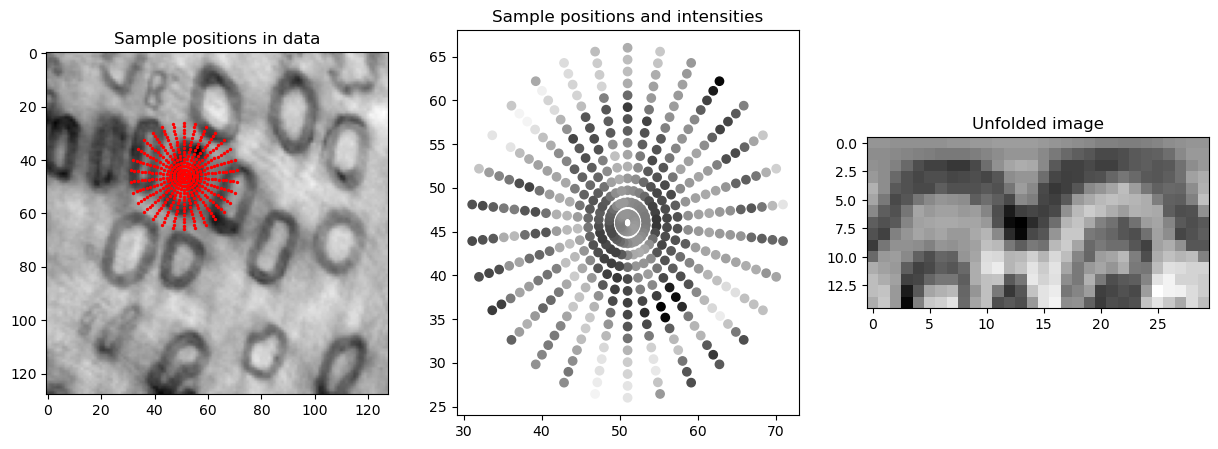

In [5]:
samples, sample_points = unfold_image(data, center=centers[8,:])

plt.figure(figsize=(15, 5))
ax = plt.subplot(1, 3, 1, title='Sample positions in data')
ax.imshow(data, cmap='gray')
ax.scatter(sample_points[..., 1], sample_points[..., 0], s=2, color='red')
ax = plt.subplot(1, 3, 2, title='Sample positions and intensities')
ax.scatter(sample_points[..., 1], sample_points[..., 0], c=samples, cmap='gray')
ax = plt.subplot(1, 3, 3, title='Unfolded image')
ax.imshow(samples, cmap='gray')
plt.show()

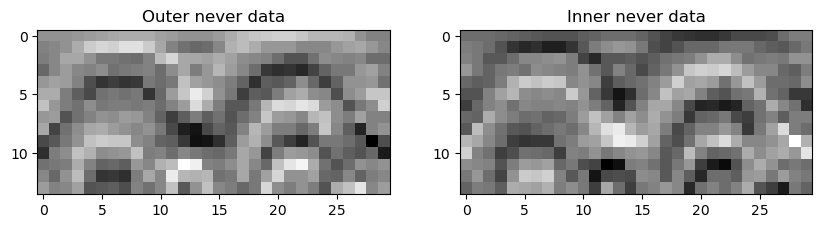

In [6]:
from slgbuilder import GraphObject, MaxflowBuilder

# Create gradient-based objects.
diff_samples = np.diff(samples, axis=0)
outer_nerve = GraphObject(255 - diff_samples)
inner_nerve = GraphObject(diff_samples)

# Show object data.
plt.figure(figsize=(10, 5))
ax = plt.subplot(1, 2, 1, title='Outer never data')
ax.imshow(outer_nerve.data, cmap='gray')
ax = plt.subplot(1, 2, 2, title='Inner never data')
ax.imshow(inner_nerve.data, cmap='gray')
plt.show()


In [7]:
helper = MaxflowBuilder()
helper.add_objects([outer_nerve, inner_nerve])
helper.add_layered_boundary_cost()
helper.add_layered_smoothness(delta=2)
helper.add_layered_containment(outer_nerve, inner_nerve, min_margin=3, max_margin=6)

flow = helper.solve()
print('Maximum flow/minimum energy:', flow)


Maximum flow/minimum energy: 1923


/dtu/3d-imaging-center/QIM/conda/miniconda3/envs/qim-base/lib/python3.11/site-packages/numpy/lib/function_base.py:2455: UserWarning: enum class termtype not importable from thinmaxflow.src._maxflow. You are probably using a cpdef enum declared in a .pxd file that does not have a .py  or .pyx file.
  outputs = ufunc(*inputs)


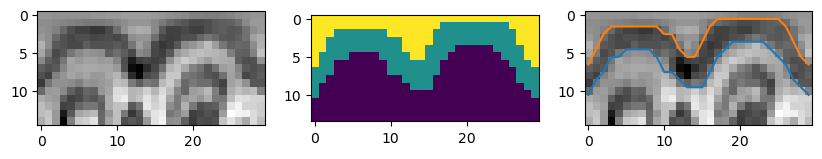

In [8]:
segmentations = [helper.get_labels(o).astype(np.int32) for o in helper.objects]
segmentation_lines = [np.count_nonzero(s, axis=0) - 0.5 for s in segmentations]

# Draw results.
plt.figure(figsize=(10, 10))
ax = plt.subplot(1, 3, 1)
ax.imshow(samples, cmap='gray')
ax = plt.subplot(1, 3, 2)
ax.imshow(np.sum(segmentations, axis=0))
ax = plt.subplot(1, 3, 3)
ax.imshow(samples, cmap='gray')
for line in segmentation_lines:
    ax.plot(line)
plt.show()


Run for multiple objects

In [9]:
# Lists for storing nerve objects.
nerve_samples = []
outer_nerves = []
inner_nerves = []

# For each center, create an inner and outer never.
for center in centers:
    # Unfold nerve.
    samples, sample_points = unfold_image(data, center)
    nerve_samples.append(samples)
    
    # Create outer and inner nerve objects.
    diff_samples = np.diff(samples, axis=0)
    diff_sample_points = sample_points[:-1]
    
    outer_nerves.append(GraphObject(255 - diff_samples, diff_sample_points))
    inner_nerves.append(GraphObject(diff_samples, diff_sample_points))

In [10]:
from slgbuilder import QPBOBuilder

helper = QPBOBuilder()
helper.add_objects(outer_nerves + inner_nerves)
helper.add_layered_boundary_cost()
helper.add_layered_smoothness(delta=2)

for outer_nerve, inner_nerve in zip(outer_nerves, inner_nerves):
    helper.add_layered_containment(outer_nerve, inner_nerve, min_margin=3, max_margin=6)

# Add exclusion constraints between all pairs of outer nerves.
for i in range(len(outer_nerves)):
    for j in range(i + 1, len(outer_nerves)):
        helper.add_layered_exclusion(outer_nerves[i], outer_nerves[j], margin=3)

/tmp/pbs.331898.hnode41/ipykernel_28965/550892667.py:14: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  helper.add_layered_exclusion(outer_nerves[i], outer_nerves[j], margin=3)
/tmp/pbs.331898.hnode41/ipykernel_28965/550892667.py:14: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  helper.add_layered_exclusion(outer_nerves[i], outer_nerves[j], margin=3)
/tmp/pbs.331898.hnode41/ipykernel_28965/550892667.py:14: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  helper.add_layered_exclusion(outer_nerves[i], outer_nerves[j], margin=3)
/tmp/pbs.331898.hnode41/ipykernel_28965/550892667.py:14: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  helper.add_layered_exclusion(outer_nerves[i],

In [11]:
flow = helper.solve()
print('Maximum flow/minimum energy:', flow)

Maximum flow/minimum energy: 48586


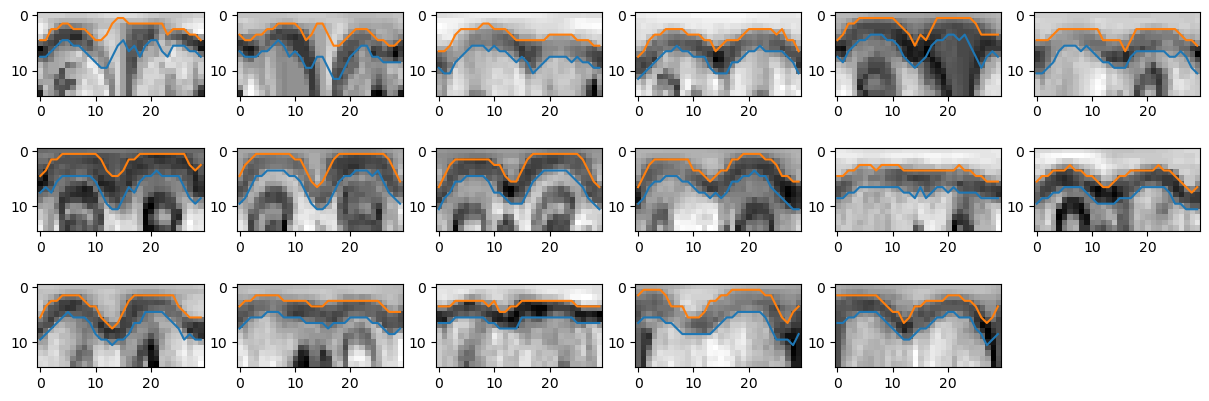

In [12]:
# Get segmentations.
segmentations = []
for outer_nerve, inner_nerve in zip(outer_nerves, inner_nerves):
    segmentations.append(helper.get_labels(outer_nerve))
    segmentations.append(helper.get_labels(inner_nerve))

segmentation_lines = [np.count_nonzero(s, axis=0) - 0.5 for s in segmentations]

# Draw segmentations.
plt.figure(figsize=(15, 5))
for i, samples in enumerate(nerve_samples):
    ax = plt.subplot(3, len(nerve_samples) // 3 + 1, i + 1)
    ax.imshow(samples, cmap='gray')
    
    ax.plot(segmentation_lines[2*i])
    ax.plot(segmentation_lines[2*i + 1])

plt.show()


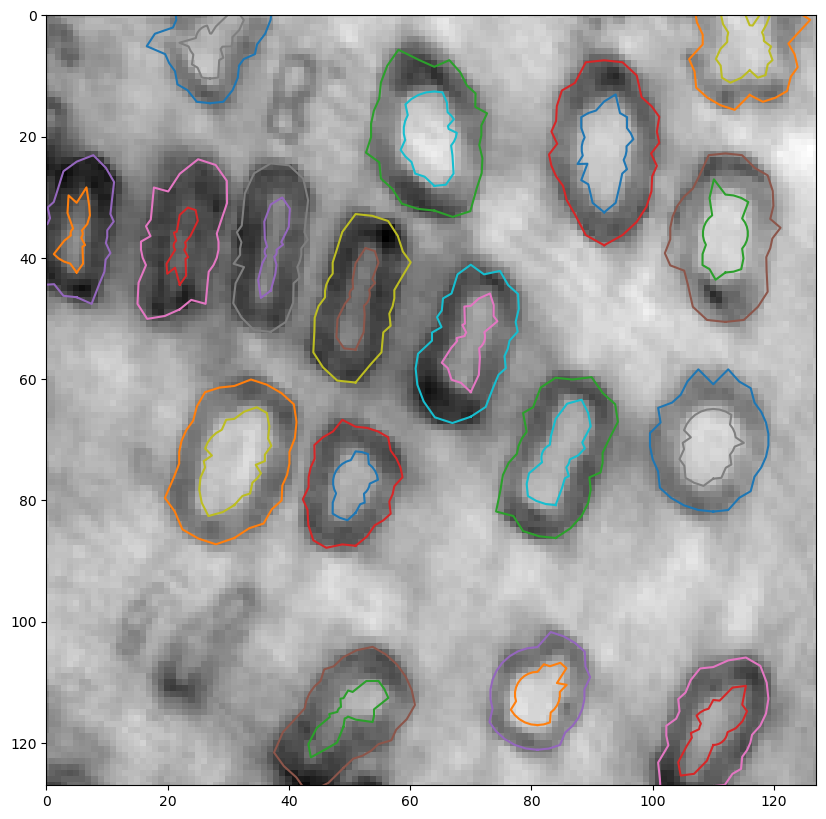

In [13]:
def draw_segmentations(data, helper):
    """Draw all segmentations for objects in the helper on top of the data."""
    
    # Create figure.
    plt.figure(figsize=(10, 10))
    plt.imshow(data, cmap='gray')
    plt.xlim([0, data.shape[1]-1])
    plt.ylim([data.shape[0]-1, 0])

    # Draw segmentation lines.
    for i, obj in enumerate(helper.objects):

        # Get segmentation.
        segment = helper.get_labels(obj)

        # Create line.
        line = np.count_nonzero(segment, axis=0)

        # Get actual points.
        point_indices = tuple(np.asarray([line - 1, np.arange(len(line))]))
        points = obj.sample_points[point_indices]
        # Close line.
        points = np.append(points, points[:1], axis=0)

        # Plot points.
        plt.plot(points[..., 1], points[..., 0])

    plt.show()
    
draw_segmentations(data, helper)